# Incidence du syndrome grippal

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1984 et se termine avec une semaine récente.

In [2]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-3.csv"

Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| week           | Semaine calendaire (ISO 8601)                                                                                                     |
| indicator      | Code de l'indicateur de surveillance                                                                                              |
| inc            | Estimation de l'incidence de consultations en nombre de cas                                                                       |
| inc_low        | Estimation de la borne inférieure de l'IC95% du nombre de cas de consultation                                                     |
| inc_up         | Estimation de la borne supérieure de l'IC95% du nombre de cas de consultation                                                     |
| inc100         | Estimation du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants)                                   |
| inc100_low     | Estimation de la borne inférieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_up      | Estimation de la borne supérieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| geo_insee      | Code de la zone géographique concernée (Code INSEE) http://www.insee.fr/fr/methodes/nomenclatures/cog/                            |
| geo_name       | Libellé de la zone géographique (ce libellé peut être modifié sans préavis)                                                       |

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant `skiprows=1`.

In [3]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data[:10]

week  indicator     inc   inc_low    inc_up  inc100  inc100_low  \
0  201911          3   35094   29031.0   41157.0      53        44.0   
1  201910          3   50623   44000.0   57246.0      77        67.0   
2  201909          3   88354   79564.0   97144.0     134       121.0   
3  201908          3  172604  160024.0  185184.0     262       243.0   
4  201907          3  307338  291220.0  323456.0     467       443.0   
5  201906          3  394286  376782.0  411790.0     599       572.0   
6  201905          3  355785  339295.0  372275.0     540       515.0   
7  201904          3  241090  227261.0  254919.0     366       345.0   
8  201903          3  147063  135890.0  158236.0     223       206.0   
9  201902          3   75548   67632.0   83464.0     115       103.0   

   inc100_up geo_insee geo_name  
0       62.0        FR   France  
1       87.0        FR   France  
2      147.0        FR   France  
3      281.0        FR   France  
4      491.0        FR   France  
5      626.0        FR   France  
6      565.0        FR   France  
7      387.0        FR   France  
8      240.0        FR   France  
9      127.0        FR   France

Y a-t-il des points manquants dans ce jeux de données ? Oui, la semaine 19 de l'année 1989 n'a pas de valeurs associées.

In [4]:
raw_data[raw_data.isnull().any(axis=1)]

week  indicator  inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
1557  198919          3    0      NaN     NaN       0         NaN        NaN   

     geo_insee geo_name  
1557        FR   France

Nous éliminons ce point, ce qui n'a pas d'impact fort sur notre analyse qui est assez simple.

In [5]:
data = raw_data.dropna().copy()
data[:10]

week  indicator     inc   inc_low    inc_up  inc100  inc100_low  \
0  201911          3   35094   29031.0   41157.0      53        44.0   
1  201910          3   50623   44000.0   57246.0      77        67.0   
2  201909          3   88354   79564.0   97144.0     134       121.0   
3  201908          3  172604  160024.0  185184.0     262       243.0   
4  201907          3  307338  291220.0  323456.0     467       443.0   
5  201906          3  394286  376782.0  411790.0     599       572.0   
6  201905          3  355785  339295.0  372275.0     540       515.0   
7  201904          3  241090  227261.0  254919.0     366       345.0   
8  201903          3  147063  135890.0  158236.0     223       206.0   
9  201902          3   75548   67632.0   83464.0     115       103.0   

   inc100_up geo_insee geo_name  
0       62.0        FR   France  
1       87.0        FR   France  
2      147.0        FR   France  
3      281.0        FR   France  
4      491.0        FR   France  
5      626.0        FR   France  
6      565.0        FR   France  
7      387.0        FR   France  
8      240.0        FR   France  
9      127.0        FR   France

Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [6]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [7]:
sorted_data = data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

Ceci s'avère tout à fait juste sauf pour deux périodes consécutives
entre lesquelles il manque une semaine.

Nous reconnaissons ces dates: c'est la semaine sans observations
que nous avions supprimées !

In [8]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

1989-05-01/1989-05-07 1989-05-15/1989-05-21


Un premier regard sur les données !

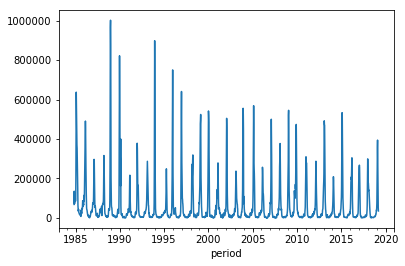

In [9]:
sorted_data['inc'].plot()

Un zoom sur les dernières années montre mieux la situation des pics en hiver. Le creux des incidences se trouve en été.

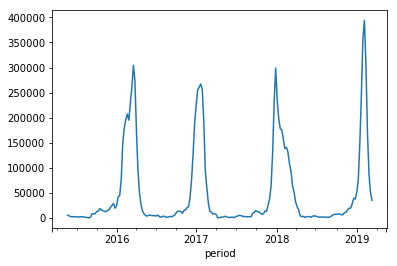

In [10]:
sorted_data['inc'][-200:].plot()

## Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en hiver, à cheval
entre deux années civiles, nous définissons la période de référence
entre deux minima de l'incidence, du 1er août de l'année $N$ au
1er août de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er août de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er août.

Comme l'incidence de syndrome grippal est très faible en été, cette
modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent an octobre 1984, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1985.

In [11]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1985,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er août, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [12]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voici les incidences annuelles.

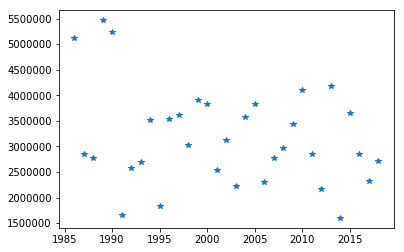

In [13]:
yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [14]:
yearly_incidence.sort_values()

2014    1600941
1991    1659249
1995    1840410
2012    2175217
2003    2234584
2006    2307352
2017    2321583
2001    2529279
1992    2574578
1993    2703886
2018    2705325
1988    2765617
2007    2780164
1987    2855570
2016    2856393
2011    2857040
2008    2973918
1998    3034904
2002    3125418
2009    3444020
1994    3514763
1996    3539413
2004    3567744
1997    3620066
2015    3654892
2000    3826372
2005    3835025
1999    3908112
2010    4111392
2013    4182691
1986    5115251
1990    5235827
1989    5466192
dtype: int64

Enfin, un histogramme montre bien que les épidémies fortes, qui touchent environ 10% de la population
  française, sont assez rares: il y en eu trois au cours des 35 dernières années.

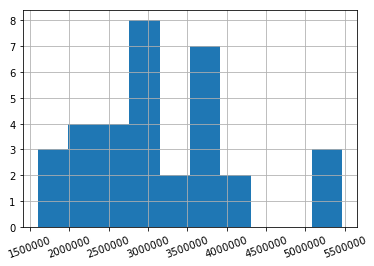

In [15]:
yearly_incidence.hist(xrot=20)